In [1]:
from typing import List
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from MRL import Matryoshka_CE_Loss, MRL_Linear_Layer

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.CIFAR10(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [ ]:
# Convolutional Autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

In [4]:
model = autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [8]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon, latent = model(images)
        loss = loss_function(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon[:8].detach().cpu(), latent[:8].detach().cpu()))

Epoch [1/20], Loss: 0.0005
Epoch [2/20], Loss: 0.0005
Epoch [3/20], Loss: 0.0005
Epoch [4/20], Loss: 0.0005
Epoch [5/20], Loss: 0.0004
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


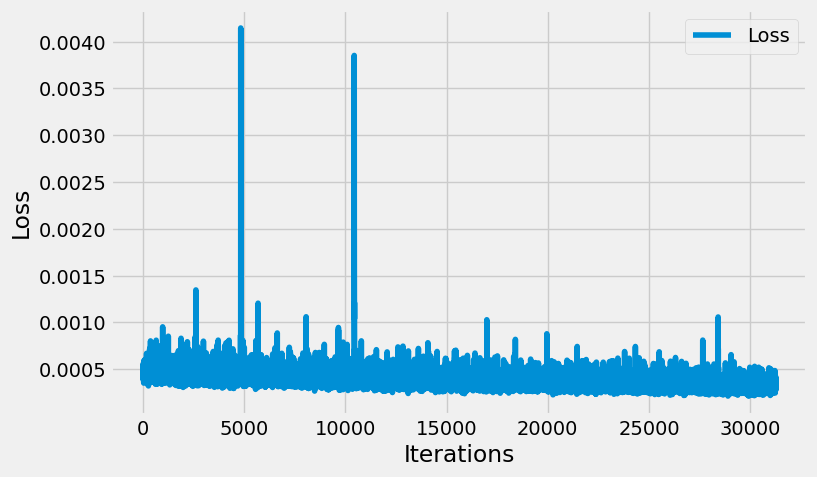

In [9]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

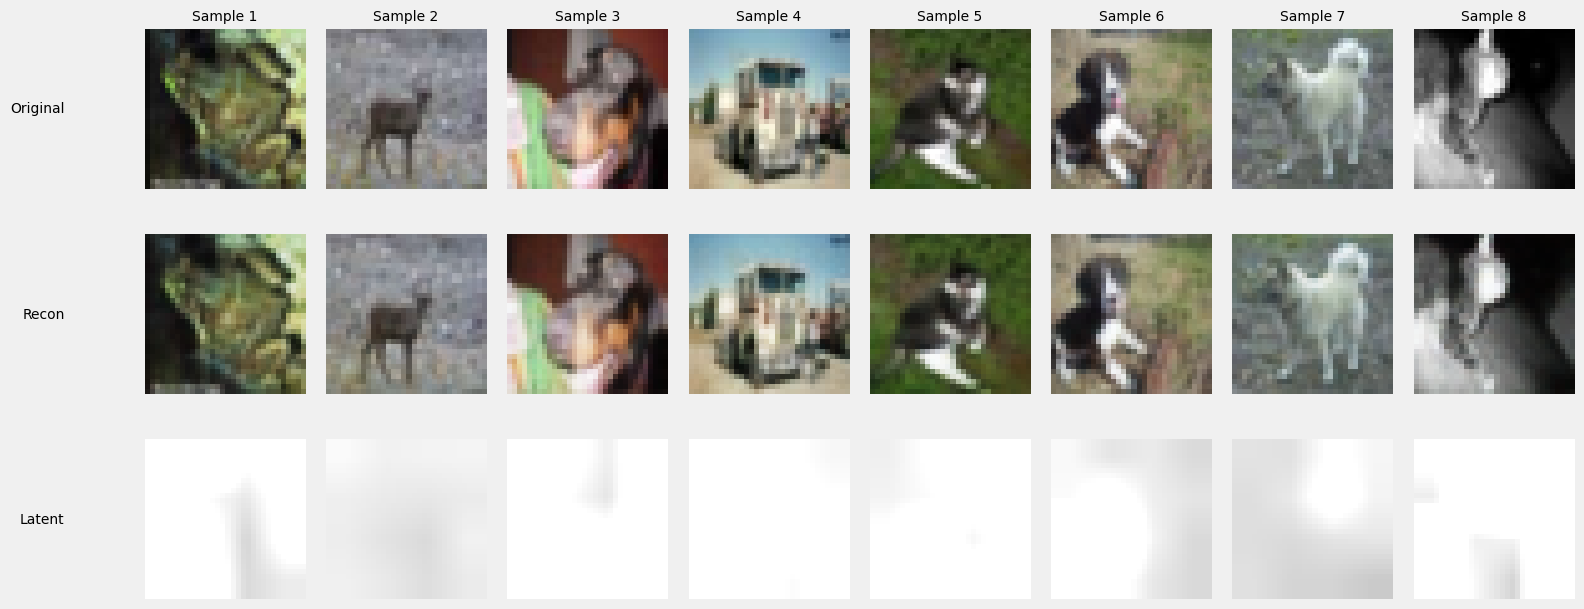

In [18]:
epoch_idx, original_imgs, recon_imgs, latents = outputs[-1]

latent_imgs = latents.mean(1, keepdim=True)  
latent_imgs = torch.nn.functional.interpolate(latent_imgs, size=(32, 32), mode='bilinear')
latent_imgs = latent_imgs.expand(-1, 3, -1, -1)  

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Latent", latent_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.savefig("../output/v7/Conv_Autoencoder.png")
plt.show()


In [17]:
torch.save(model.state_dict(), "../output/v7/Conv_Autoencoder_weight.pth")
torch.save(model, "../output/Conv_Autoencoder.pth")
print("Saved")

Saved
